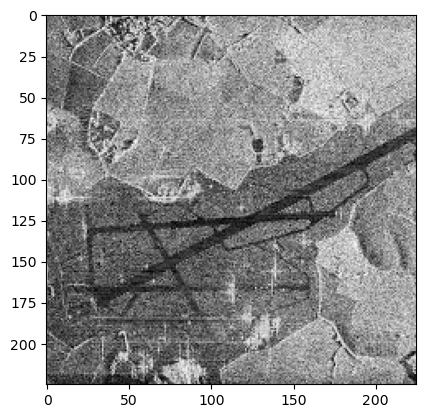

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import math

image = cv2.imread('sar_3.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap='gray')


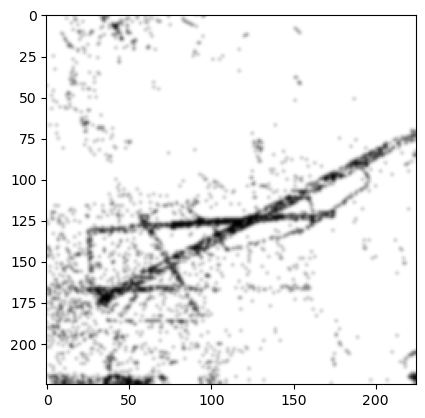

In [2]:

bin_img = copy.deepcopy(image_gray)
T  = 55
bin_img[image_gray < T] = 0
bin_img[image_gray >= T] = 255
blur = cv2.GaussianBlur(bin_img,(7,7),1)
plt.imshow(blur, cmap='gray')



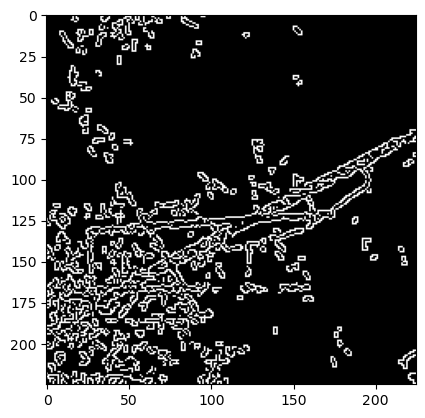

In [28]:
canny = cv2.Canny(blur, 150, 250, apertureSize=3)
plt.imshow(canny, cmap='gray')



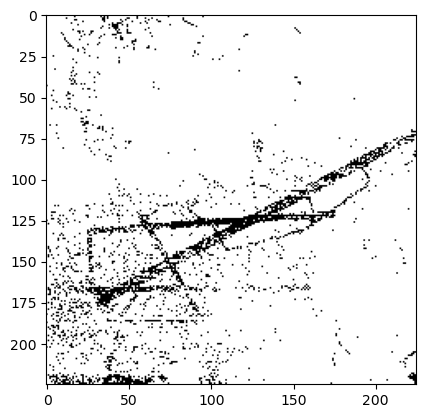

In [21]:
bin_img=cv2.bitwise_not(bin_img)
plt.imshow(bin_img, cmap='gray')

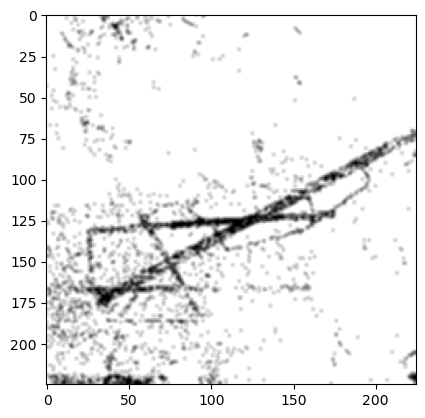

In [22]:
blur = cv2.GaussianBlur(bin_img,(3,3),1)
plt.imshow(blur, cmap='gray')

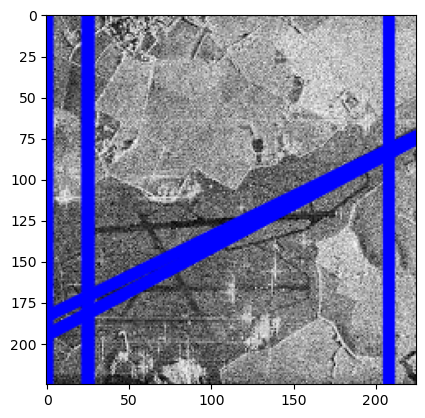

In [29]:
lines = cv2.HoughLines(canny, 1, np.pi / 180, 120)
if lines is not None:
    max_line = None
    max_length = 0
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
        length = np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)
        if length > max_length:
            max_length = length
            max_line = (pt1, pt2)
    if max_line:
        cv2.line(image, max_line[0], max_line[1], (0, 0, 255), 5, cv2.LINE_AA)

plt.imshow(image, cmap='gray')
plt.show()


Canny:
  Белые пиксели: 18621 (36.8%)
  Черные пиксели: 32004 (63.2%)

Sobel:
  Белые пиксели: 44422 (87.7%)
  Черные пиксели: 6203 (12.3%)

Adaptive:
  Белые пиксели: 26334 (52.0%)
  Черные пиксели: 24291 (48.0%)

Otsu:
  Белые пиксели: 26028 (51.4%)
  Черные пиксели: 24597 (48.6%)

Simple:
  Белые пиксели: 26776 (52.9%)
  Черные пиксели: 23849 (47.1%)


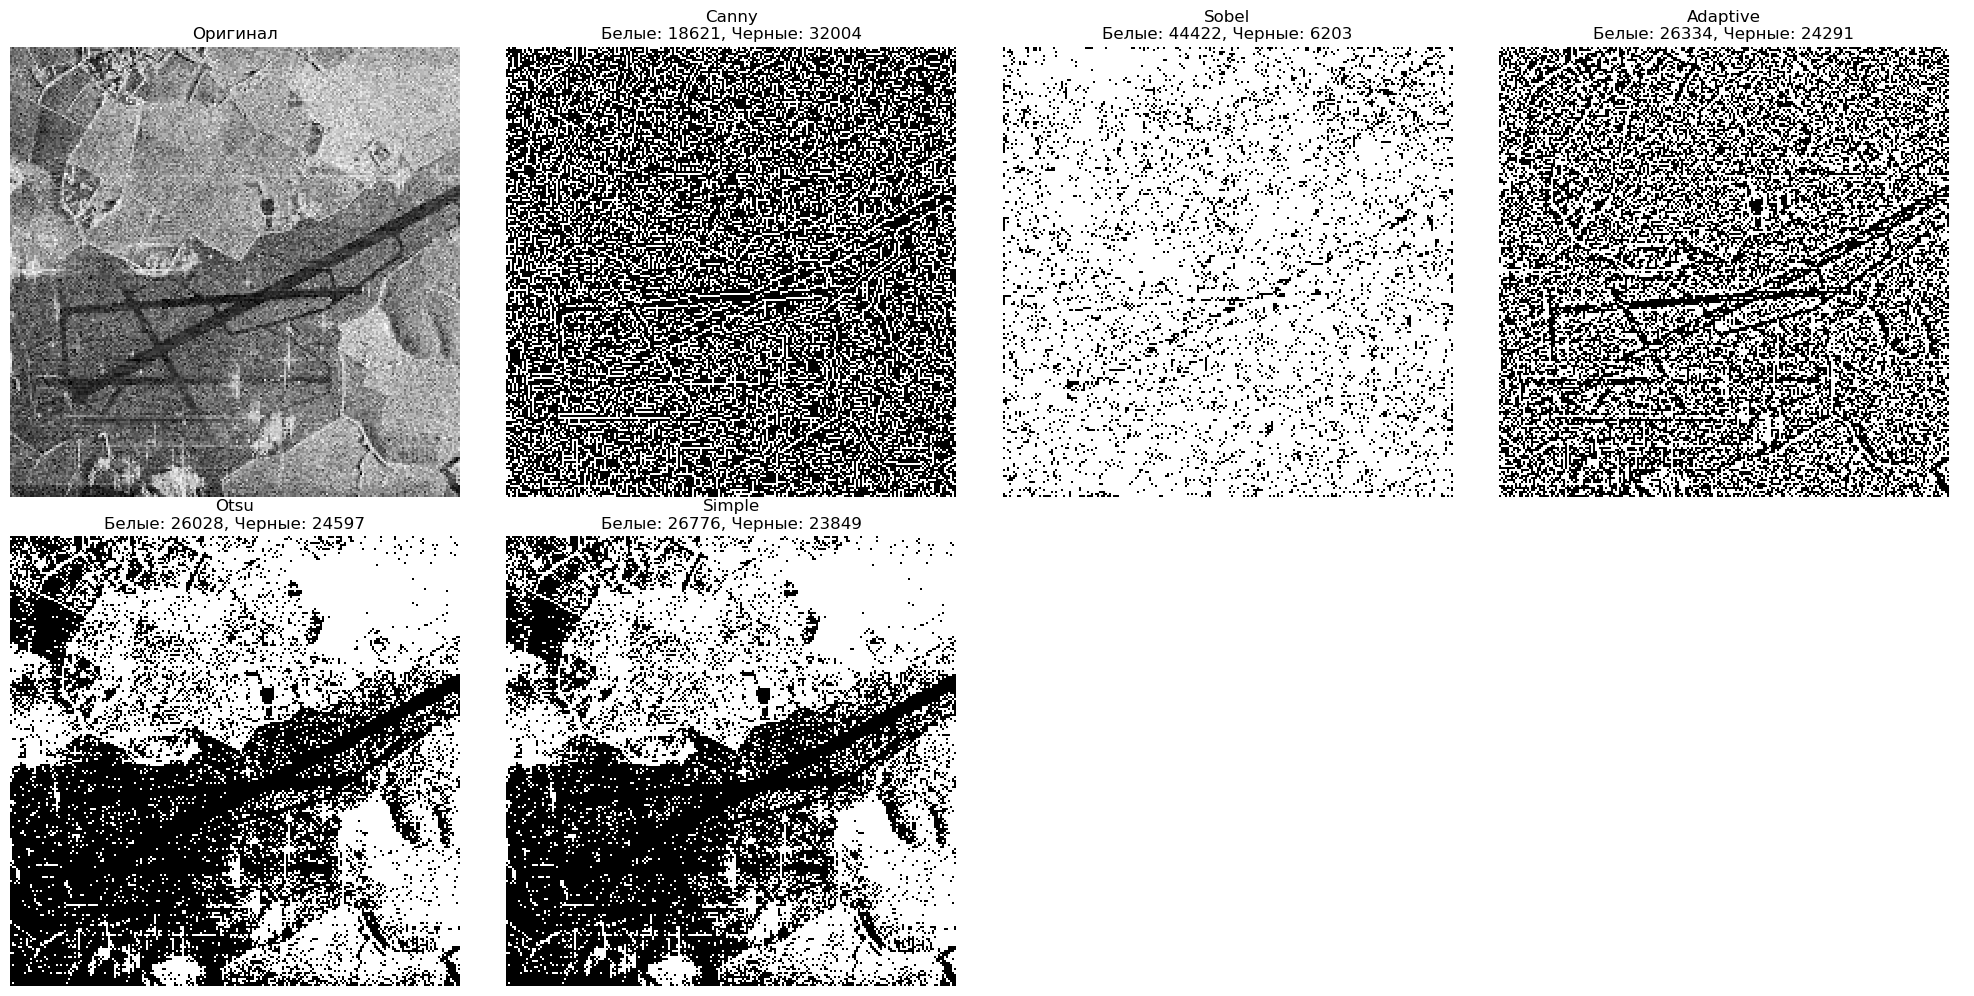

In [100]:

def count_color_pixels(binary_image):
    """Подсчет пикселей разного цвета в бинарном изображении"""
    # Для бинарных изображений (0 и 255)
    white_pixels = np.sum(binary_image == 255)
    black_pixels = np.sum(binary_image == 0)
    total_pixels = binary_image.size
    
    return white_pixels, black_pixels, total_pixels



image_paths = ['sar_3.jpg']  # Можно добавить другие изображения



    
for i, image_path in enumerate(image_paths):

    original = cv2.imread(image_path)
    if original is None:
        print(f"Ошибка загрузки: {image_path}")
        continue

    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    methods = {}

    edges_canny = cv2.Canny(gray, 50, 150)
    methods['Canny'] = edges_canny

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobel_x, sobel_y)
    sobel_binary = np.uint8(sobel_combined > 50) * 255
    methods['Sobel'] = sobel_binary

    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, 11, 2)
    methods['Adaptive'] = adaptive_thresh

    _, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    methods['Otsu'] = otsu_thresh

    _, simple_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    methods['Simple'] = simple_thresh

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Оригинал')
    axes[0].axis('off')

    for idx, (method_name, binary_img) in enumerate(methods.items(), 1):
        axes[idx].imshow(binary_img, cmap='gray')

        white_pixels, black_pixels, total_pixels = count_color_pixels(binary_img)

        axes[idx].set_title(f'{method_name}\n'
                          f'Белые: {white_pixels}, Черные: {black_pixels}')
        axes[idx].axis('off')

        print(f"\n{method_name}:")
        print(f"  Белые пиксели: {white_pixels} ({white_pixels/total_pixels*100:.1f}%)")
        print(f"  Черные пиксели: {black_pixels} ({black_pixels/total_pixels*100:.1f}%)")

    if len(methods) < 6:
        for i in range(len(methods) + 1, 8):
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()